# Packet Breakdown 

## Importanto bibliotecas necessárias

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

%matplotlib inline

In [2]:
# deixar a pasta scripts vizivel no notebook
%load_ext autoreload
%autoreload 2

import sys
import os

module_path = os.path.abspath(os.path.join('..', 'pyscripts'))
if module_path not in sys.path :
    sys.path.append(module_path)

In [3]:
# import module from scripts folder
import process_data

## Pré-processamento dos dados

In [4]:
## import dataset from ../data
dataFolder = os.path.join('..','Simulations')

# the same file will be searching
mainFile = 'packet_breakdown.txt' 

simulationFolders = ["PA", "PB", "CL2", "CL4", "CLBinomial"]

dfData = pd.DataFrame()

for folder in simulationFolders:
    data_file = os.path.join(dataFolder,folder,mainFile)
#     df = process_data.parser_main_table(data_file)
    df = process_data.parser_main_table(data_file)
    df['Simulation'] = folder
    dfData = dfData.append(df,ignore_index=True)

del df

In [5]:
dfData.columns

Index(['info_0', 'info_1', 'info_2', 'Failed, buffer overflow',
       'Failed, busy channel', 'Failed, no ack', 'Success, first try',
       'Success, not first try', 'Simulation'],
      dtype='object')

In [6]:
dfData.head()

,info_0,info_1,info_2,"Failed, buffer overflow","Failed, busy channel","Failed, no ack","Success, first try","Success, not first try",Simulation
0,setRateHigh,InterfModel=0,node=1,0,0.03636,0.02924,0.73991,0.19448,PA
1,setRateHigh,InterfModel=0,node=2,0,0.03415,0.01313,0.76674,0.18598,PA
2,setRateHigh,InterfModel=0,node=3,0,0.02313,0.04063,0.75252,0.18372,PA
3,setRateHigh,InterfModel=0,node=4,0.12637,0.01254,0.01919,0.70874,0.13315,PA
4,setRateHigh,InterfModel=0,node=5,0.15026,0.01161,0.02518,0.70296,0.11,PA


### Certificar que os tipos de dados são apropriados

In [7]:
numericColumns = [
    'Failed, buffer overflow',
    'Failed, busy channel' ,
    'Failed, no ack',
    'Success, first try',
    'Success, not first try'
]

dfData[numericColumns] = dfData[numericColumns].astype('float')
dfData[numericColumns] *= 100

In [8]:
nodes_PT = { 
        'node=1': 'E-Punho',
        'node=2': 'D-Punho',
        'node=3': 'E-Tornozelo',
        'node=4': 'D-Tornozelo',
        'node=5': 'Peito',
        'node=0' : 'Cintura'
    }

nodes_ENG = { 
        'node=1': 'L-wrist',
        'node=2': 'R-wrist',
        'node=3': 'L-ankle',
        'node=4': 'R-ankle',
        'node=5': 'chest',
    }

def infer_node(value,mapper=nodes_PT):
    return mapper[value]

dfData['info_1'] = dfData['info_1'].apply(infer_node)

KeyError: 'InterfModel=0'

In [9]:
def clean_attr(str_value):
    index = str_value.find('=')
    if index >= 0 :
        return str_value[(index+1):]
    else:
        return str_value
    
def change_collisionModel_attr(str_value):
    
    index = clean_attr(str_value)
    
    if index == '1':
        return 'with interference' # 'with collision'
    else: # == 0
        return 'without interference' # 'without collision'
    
dfData['info_0'] = dfData['info_0'].apply(change_collisionModel_attr)

In [10]:
# columnTranslate = {
#     'info_0' : 'Modelo de colisão',
#     'info_1' : 'Nó sensor',
#     'info_2' : 'Repetição',
#     'Failed, buffer overflow': 'Falha, estouro de buffer',
#     'Failed, busy channel' : 'Falha, canal ocupado',
#     'Failed, no ack': 'Falha, não recebimento ACK', 
#     'Success, first try' : 'Sucesso, primeira tentativa',
#     'Success, not first try' : 'Sucesso, retransmissão',
#     'Simulation' : 'Simulação'
# }

columnTranslate = {
    'info_0' : 'Collision model',
    'info_1' : 'Node',
    'info_2' : 'Repetition',
}

dfData.rename(mapper=columnTranslate,axis='columns', inplace=True)

In [11]:
dfData.head()

,Collision model,Node,Repetition,"Failed, buffer overflow","Failed, busy channel","Failed, no ack","Success, first try","Success, not first try",Simulation
0,without interference,InterfModel=0,node=1,0.000,3.636,2.924,73.991,19.448,PA
1,without interference,InterfModel=0,node=2,0.000,3.415,1.313,76.674,18.598,PA
2,without interference,InterfModel=0,node=3,0.000,2.313,4.063,75.252,18.372,PA
3,without interference,InterfModel=0,node=4,12.637,1.254,1.919,70.874,13.315,PA
4,without interference,InterfModel=0,node=5,15.026,1.161,2.518,70.296,11.000,PA


In [12]:
dfData.dtypes

Collision model             object
Node                        object
Repetition                  object
Failed, buffer overflow    float64
Failed, busy channel       float64
Failed, no ack             float64
Success, first try         float64
Success, not first try     float64
Simulation                  object
dtype: object

## Visualization 

In [13]:
# save images at ..
imageFolder = 'images'
isSaveImage = True

def save_image(img,file_name,file_ext='.png'):
    
    if not isSaveImage:
        return
    
    if not file_name.endswith(file_ext):
        file_name += file_ext
    
    if type(img) == sns.axisgrid.FacetGrid :
        img.savefig(os.path.join(imageFolder,file_name))

In [14]:
def barplot(dfdata,y_label, collisionModel=None):
    
    image_file_name = y_label
    
    if collisionModel :
        dfdata = dfdata[dfdata['Collision model'] == collisionModel]
        image_file_name += ('_' + str(collisionModel))
        
    # método do seaborn - categorical plot
    g = sns.catplot(data=dfdata,
                    x='Node',
                    y=y_label,
                    hue='Simulation',
                    hue_order=["CL","PA","PB"],
                    col='Collision model',
                    kind='bar',
                    height=5,
                    aspect=2,
                    sharey=False,
                    legend_out=True,
                    ci=None
                   )
    # g.set_titles(col_template='{col_var} : {col_name}') 
    # help(g.set_titles) # para obter mais ajuda
    g.set_titles(col_template='{col_var} {col_name}')

    # Define o intervalo do eixo x
#     g.set(ylim=(40,105))
    
    save_image(g,image_file_name)
    
    return g


In [15]:
barplot(dfData,'Success, first try','with interference')

IndexError: index 0 is out of bounds for axis 1 with size 0

<Figure size 0x360 with 0 Axes>

In [16]:
for label in numericColumns:
    barplot(dfData,label,'with interference')

IndexError: index 0 is out of bounds for axis 1 with size 0

<Figure size 0x360 with 0 Axes>

In [17]:
dfData['Simulation'].unique()

array(['PA', 'PB', 'CL2', 'CL4', 'CLBinomial'], dtype=object)

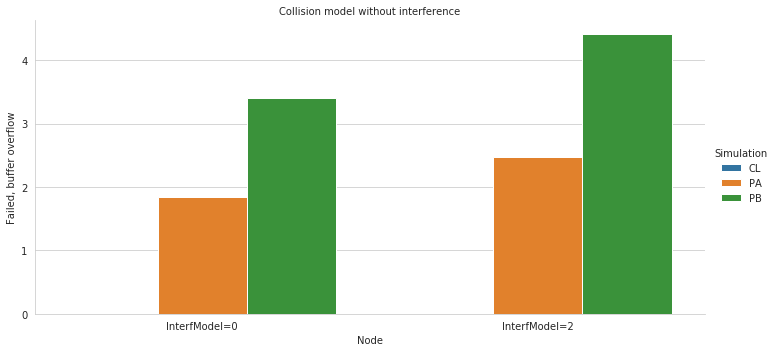

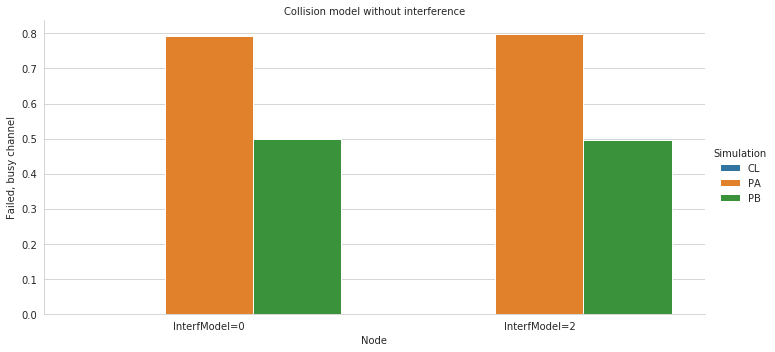

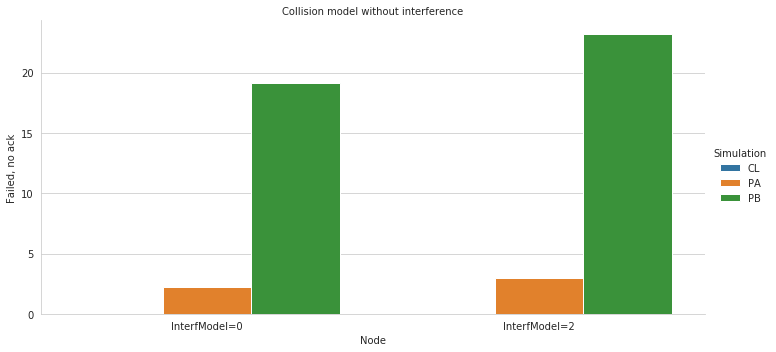

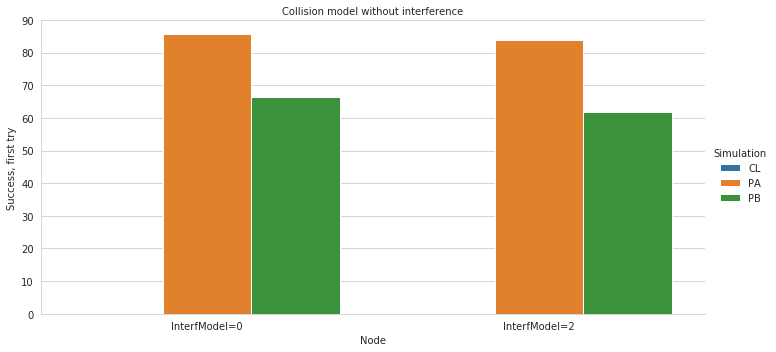

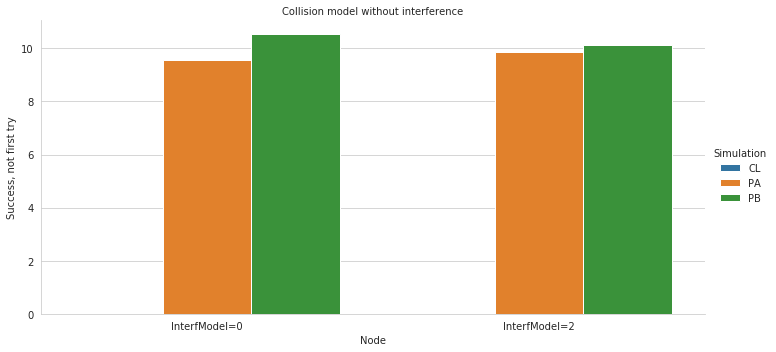

In [18]:
for label in numericColumns:
    barplot(dfData,label,'without interference')

In [19]:
# g = sns.catplot(data=dfData,
#                 x='Nó sensor',
#                 y='Sucesso, retransmissão',
#                 hue='Simulação',
#                 hue_order=["CL","PA","PB"],
#                 col='Modelo de colisão',
#                 kind='bar',
#                 height=5,
#                 aspect=2
#                )

In [20]:
# g = sns.catplot(data=dfData,
#                 x='Nó sensor',
#                 y='Falha, estouro de buffer',
#                 hue='Simulação',
#                 hue_order=["CL","PA","PB"],
#                 col='Modelo de colisão',
#                 kind='bar',
#                 height=5,
#                 aspect=2
#                )

In [21]:
# g = sns.catplot(data=dfData,
#                 x='Nó sensor',
#                 y='Falha, canal ocupado',
#                 hue='Simulação',
#                 hue_order=["CL","PA","PB"],
#                 col='Modelo de colisão',
#                 kind='bar',
#                 height=5,
#                 aspect=2
#                )

In [22]:
# g = sns.catplot(data=dfData,
#                 x='Nó sensor',
#                 y='Falha, não recebimento ACK',
#                 hue='Simulação',
#                 hue_order=["CL","PA","PB"],
#                 col='Modelo de colisão',
#                 kind='bar',
#                 height=5,
#                 aspect=2
#                )

In [23]:
## Stacked bar plot

In [24]:
# df = dfData[(dfData['Modelo de colisão'] == 'com colisão' ) & (dfData['Simulação'] == 'PB')]
# df = df.drop(columns=['Modelo de colisão', 'Simulação'])
# df.set_index('Nó sensor').plot(kind='bar', stacked=True,legend=False)
